In [48]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from convolution.conv_2d import Conv2D
from convolution.conv_3d import Conv3D
from pooling.maxpool_3d import MaxPooling3D

from pooling.maxpool_2d import MaxPooling2D
from layers.layer_dense import Layer_Dense
from activation_func.relu import Activation_ReLU
from loss.activation_softmax_loss_categorical_crossentropy import Activation_Softmax_Loss_CategoricalCrossentropy
from optimizers.adam import Optimizer_Adam 
from model.model import Model
from layers.flatten import Flatten
from activation_func.softmax import Activation_Softmax
from loss.categorical_cross_entropy import Loss_CategoricalCrossentropy
from accuracy.accuracy_categorical import Accuracy_Categorical

In [49]:
#load datasets
test_csv_path='mnist/mnist/test.csv'
train_csv_path='mnist/mnist/train.csv'

In [50]:
#load the dataset
train_data=pd.read_csv(train_csv_path)
test_data=pd.read_csv(test_csv_path)

In [51]:
#split the dataset and normalize 
y_train = train_data['label'].values
x_train = train_data.drop(columns=['label']).values/255
X_test = test_data.values/255

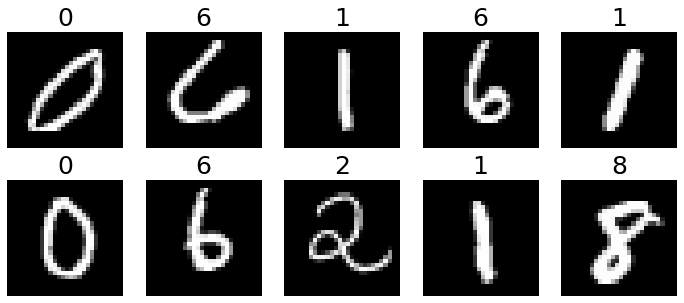

In [52]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

The idea here is to try to implement LeNet(5) implementation but instead of using avr-pooling and sigmoid we gonna try to work with Relu and max pooling with softmax      

In [57]:
#reshape x_train to be of shape [N,28,28,1] || train,val data
x_train=x_train.reshape(x_train.shape[0],28,28)
x_train=np.expand_dims(x_train,axis=3)

x_test=X_test.reshape(X_test.shape[0],28,28)
x_test=np.expand_dims(x_test,axis=3)

In [58]:
#define the model and layers 
model = Model()
model.add(Conv3D([5,5,1,6],6,padding=1,stride=1))
model.add(Activation_ReLU())
model.add(MaxPooling3D(f=2,stride=2))
model.add(Conv3D([5,5,6,16],16,padding=1,stride=1))
model.add(MaxPooling3D(f=2,stride=2))
model.add(Activation_ReLU())
model.add(Flatten())
model.add(Layer_Dense(400,200))
model.add(Activation_ReLU())
model.add(Layer_Dense(200,10))
model.add(Activation_Softmax())


In [59]:
#set loss,optimizer and accuracy 
model.set(
loss=Loss_CategoricalCrossentropy(),
optimizer=Optimizer_Adam(decay=5e-5),
accuracy=Accuracy_Categorical()
)

In [60]:
#finalize the model
model.finalize()

In [61]:
model.train(x_train,y_train,epochs=1,batch_size=32,print_every=10)

epoch1: 1


TypeError: forward() takes 2 positional arguments but 3 were given

In [27]:
ix=np.random.randint(x_train.shape[0],size=32)
#layer1
conv1=Conv3D([5,5,1,6],6,padding=1,stride=1)
relu1=Activation_ReLU()
pool1=MaxPooling3D(f=2,stride=2)
#layer2
conv2=Conv3D([5,5,6,16],16,padding=1,stride=1)
pool2=MaxPooling3D(f=2,stride=2)
relu2=Activation_ReLU()

#fc layer3
linear3=Layer_Dense(400,200)
relu3=Activation_ReLU()

#fc layer4 + softmax
linear4=Layer_Dense(200,10)

loss_activation=Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer =Optimizer_Adam(learning_rate=0.1, decay=1e-5)


x_train_batch=x_train[ix]
y_train_batch=y_train[ix]

print(y_train_batch.shape)

(32,)


In [28]:
for epoch in range(100):
    #forward pass 
    conv1.forward(x_train_batch)
    relu1.forward(conv1.output,training=True)
    pool1.forward(relu1.output)

    conv2.forward(pool1.output)
    relu2.forward(conv2.output,training=False)
    pool2.forward(relu2.output)
    #flatten from [n,5,5,16] to [n,400]
    x=pool2.output.reshape(pool2.output.shape[0],-1)

    #fully connected layers
    linear3.forward(x,training=True)
    relu3.forward(linear3.output,training=True)
    linear4.forward(relu3.output,training=True)
    
    loss=loss_activation.forward(linear4.output,y_train_batch)
    #accuracy is wrong fix later
    predictions=np.argmax(loss_activation.output,axis=1)
    accuracy=np.mean(predictions==y_train_batch)

    if not epoch % 10:
        print(f'epoch: {epoch}, ' +
                f'acc: {accuracy:.3f}, ' +
                f'loss: {loss:.3f}') 

    #backward pass
    loss_activation.backward(loss_activation.output,y_train_batch)
    linear4.backward(loss_activation.dinputs)
    relu3.backward(linear4.dinputs)
    linear3.backward(relu3.dinputs)
    #re-flatten out the x shape to normal shape
    lin3_dinputs_fl=linear3.dinputs.reshape(linear3.dinputs.shape[0],5,5,16)
    pool2.backward(lin3_dinputs_fl)
    relu2.backward(pool2.dinputs)
    conv2.backward(relu2.dinputs)
    pool1.backward(conv2.dinputs)
    relu1.backward(pool1.dinputs)
    conv1.backward(relu1.dinputs)

    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(linear4)
    optimizer.update_params(linear3)
    optimizer.update_params(conv2)
    optimizer.update_params(conv1)
    
    #call once post update params 
    optimizer.post_update_params()


epoch: 0, acc: 0.094, loss: 2.303
epoch: 10, acc: 0.125, loss: 2.276
epoch: 20, acc: 0.125, loss: 2.261
epoch: 30, acc: 0.156, loss: 2.256
epoch: 40, acc: 0.156, loss: 2.256
epoch: 50, acc: 0.156, loss: 2.256
epoch: 60, acc: 0.156, loss: 2.256
epoch: 70, acc: 0.156, loss: 2.255
epoch: 80, acc: 0.156, loss: 2.255
epoch: 90, acc: 0.156, loss: 2.255
